# NeuroData Design: Sprint 1, Week 6
Vivek Gopalakrishnan | October 10, 2018

___

This week, I reached ran experiments on _struc2vec_ and implemented a new embedding method. 

**SUMMARY OF RESULTS:**
- Raw embeddings produced by _struc2vec_ are not comparable
- _struc2vec_ fails to consistently embed the same graph, demonstrating that embeddings of different graphs are not comparable
- Using simple scan statistics might be a better way of doing embedding
- The k-hop scan statistic is not as informative as _struc2vec_ but it is consistent across different graphs

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import OrderedDict

from load_emb import emb

In [2]:
# Make a consistent colormap for the nodes
cmap = plt.get_cmap('jet', 7)

### Start by visualizing the graph:
The data used for this week's experiments is a barbell graph. It consists of two fully connected networks at either end (bells), joined by a single string of nodes (bar). The two bells are identical.

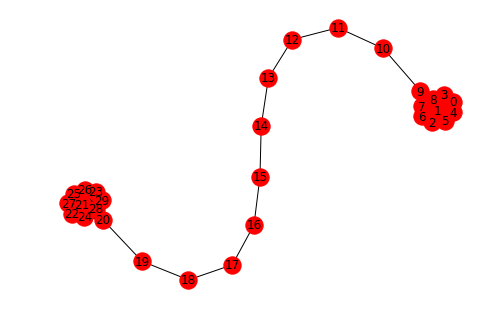

In [3]:
# Load the barbell graph
G = nx.read_edgelist('barbell.edgelist')

# Visualize it
nx.draw(G, with_labels = True)

In [4]:
# Write the labels for each node
labels = {
    0:['0'+str(x) for x in range(9)] + [str(x) for x in range(21,30)],
    1:['09','20'],
    2:['10','19'],
    3:['11','18'],
    4:['12','17'],
    5:['13','16'],
    6:['14','15']
         }

flipped_labels = {}
for key, value in labels.items():
    for x in value:
        flipped_labels[x]=key
        
labels = list(OrderedDict(sorted(flipped_labels.items())).values())

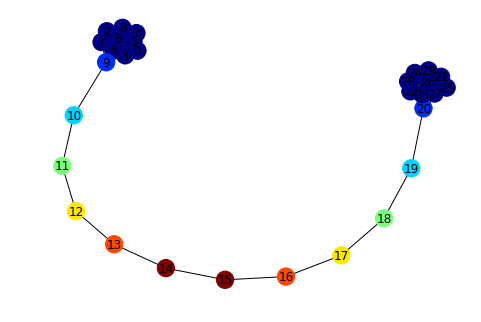

In [5]:
# Draw with colormap
nx.draw(G, 
        node_color = labels,
        cmap = cmap, 
        with_labels = True
       )
plt.show()

### Now load the embeddings made by _struc2vec_

For this experiment, the same barbell graph was run through _struc2vec_ three times. Because _struc2vec_ is a randomized algorithm, we expect each embedding to be different, even though the input is the same.

In [6]:
# Load the previously generated embeddings
t1 = emb('barbell2d-trial1.emb')
t2 = emb('barbell2d-trial2.emb')
t3 = emb('barbell2d-trial3.emb')

embeddings = [t1, t2, t3]

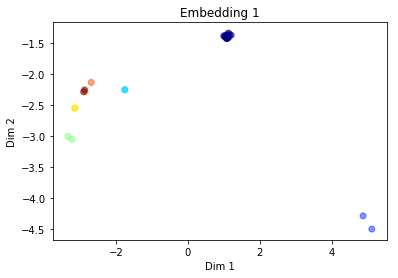

In [7]:
# Plot the first embedding
plt.scatter(x=t1.data[:,1], y=t1.data[:,2], 
            c=labels, cmap=cmap,
            alpha=0.5)

plt.title('Embedding 1')
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')

plt.show()

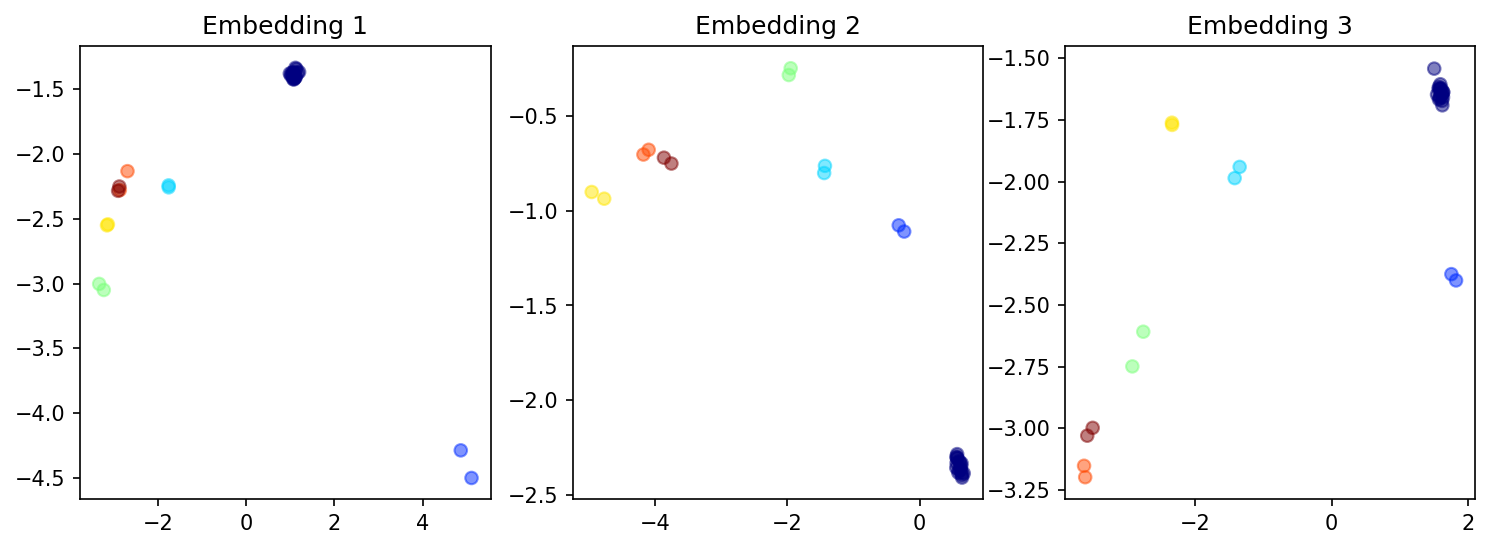

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4), dpi=150)

axes[0].scatter(x=t1.data[:,1], y=t1.data[:,2], 
                c=labels, cmap=cmap,
                alpha=0.5)
axes[0].set_title('Embedding 1')

axes[1].scatter(x=t2.data[:,1], y=t2.data[:,2], 
                c=labels, cmap=cmap,
                alpha=0.5)
axes[1].set_title('Embedding 2')

axes[2].scatter(x=t3.data[:,1], y=t3.data[:,2], 
                c=labels, cmap=cmap,
                alpha=0.5)
axes[2].set_title('Embedding 3')

plt.show()

The embeddings are completely different, showing that they cannot be compared in their raw forms.

### Analyze the graph using scan statistics

Scan statistics are statistics that are calculated on subsets of the original graph. Intuitively, they are similar to calculating some feature on a moving window over the data. In our case, the window moves over all nodes in the graph and determines that subgraph.

The feature we are calculating is the number of edges in the subgraph around a given node.

**Precise definition of locality statistic:**

Let $D$ be a graph with node set $V(D)$ and edge set $A(D)$ (A stands for "arc"). For a node $v \in V(D)$ and a scale $k$, we define the _k_-hop neighborhood of $v$ as $N_k[v] = \{ w \in V(D) : d(v,w) \leq k \}$. We denote the induced subgraph as $\Omega(N_k[v; D] = \{ w \in V(D) : d(v,w) \leq k \})$.

The specific statistic we calculate is:
$$ \psi_k(v) = | A( \Omega( N_k[v; D] ) ) | $$

In [9]:
# Find the 1-hop and 2-hop neighbors

data = []

for node in G.nodes:
    
    one_hop = list(nx.single_source_shortest_path_length(G, node, cutoff=1).keys())
    two_hop = list(nx.single_source_shortest_path_length(G, node, cutoff=2).keys())
            
    data.append([node, 
                 len(G.subgraph(one_hop).edges()), 
                 len(G.subgraph(two_hop).edges())])

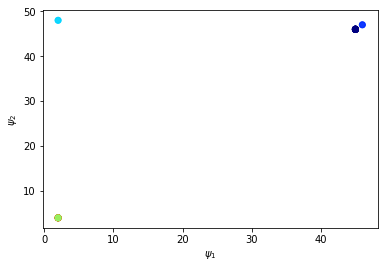

In [10]:
plt.figure()

plt.scatter([line[1] for line in data], 
            [line[2] for line in data], 
            c=labels, cmap=cmap,
            alpha=0.75
           )

plt.xlabel('$\psi_1$')
plt.ylabel('$\psi_2$')
plt.show()

### Final figure

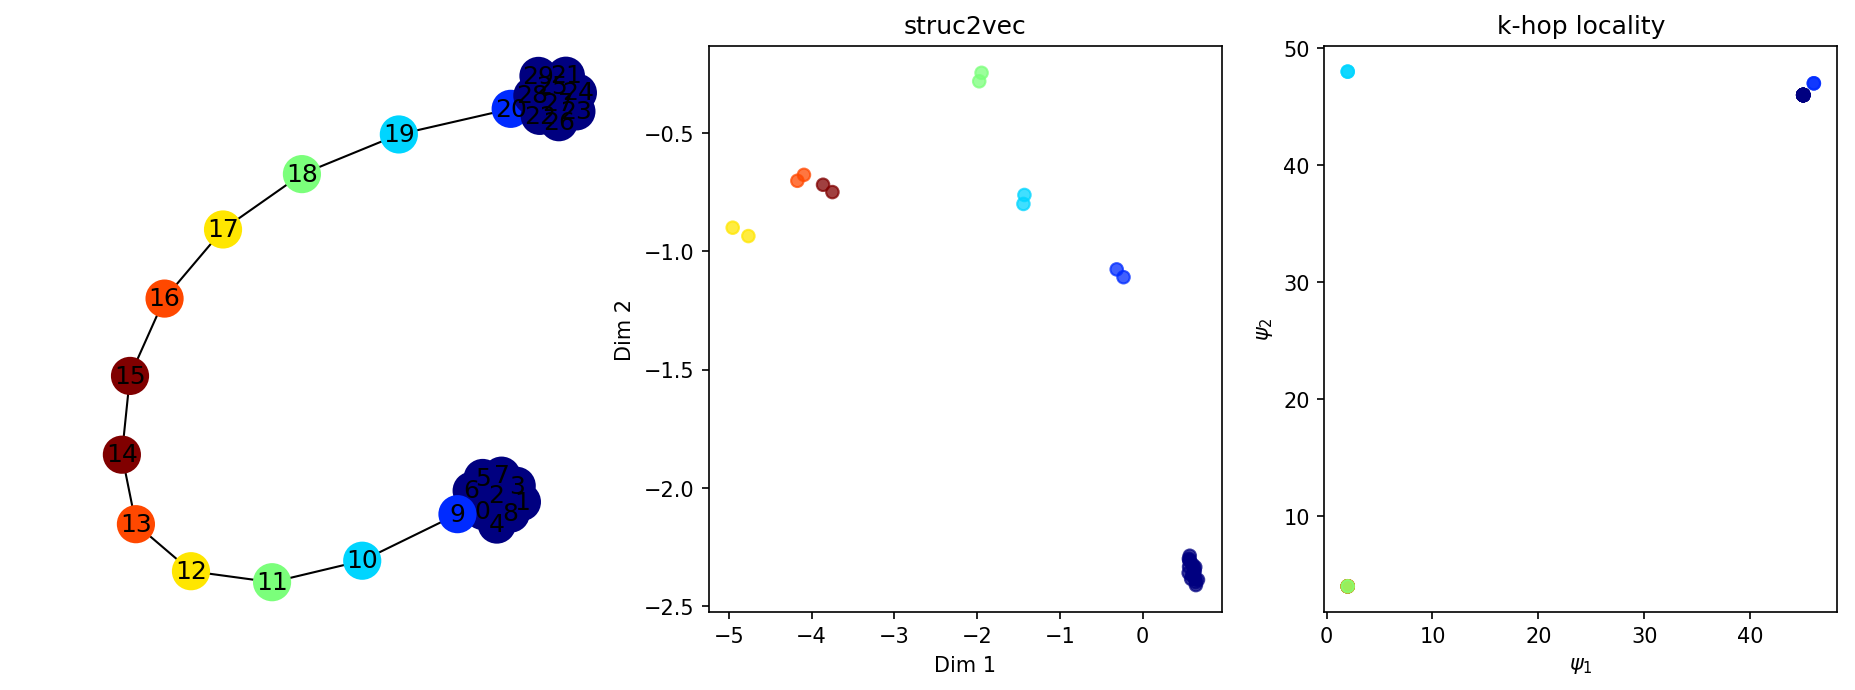

In [11]:
figparams={'figsize':(15,5), 'dpi':150}
plt.figure(**figparams)

# Plot 1
plt.subplot(131)
nx.draw(G, node_color = labels, cmap = cmap, with_labels = True)

# Plot 2
plt.subplot(132)
plt.scatter(x=t2.data[:,1], y=t2.data[:,2], 
            c=labels, cmap=cmap,
            alpha=0.75)

plt.title('struc2vec')
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')

# Plot 3
plt.subplot(133)
plt.scatter([line[1] for line in data], 
            [line[2] for line in data], 
            c=labels, cmap=cmap,
            alpha=0.75
           )
plt.title('k-hop locality')
plt.xlabel('$\psi_1$')
plt.ylabel('$\psi_2$')

plt.show()

From these experiments, I determine that for our purposes, scan statistics are a better method for generating embeddings of graphs than _struc2vec_. While the embedding produced by _k_-hop locality is not as detailed as the embedding produced by _struct2vec_, it is consistent. That means that embeddings produced by scan statistics can be compared to each other, which is not the case for embeddings produced by _struc2vec_. Because we are interested in clustering a set of graphs and not a set of nodes within a graph, it is justifiable to sacrifice the detail obtained from _struc2vec_ in favor of the consistent representation returned by scan statistics.